In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dataset-hijaiyah/Dataset Hijaiyah/Hijaiyah kasrah/4_Tsi/Ponpes At Taufiq M.6-32.wav
/kaggle/input/dataset-hijaiyah/Dataset Hijaiyah/Hijaiyah kasrah/4_Tsi/Ponpes At Taufiq F.2-34.wav
/kaggle/input/dataset-hijaiyah/Dataset Hijaiyah/Hijaiyah kasrah/4_Tsi/Ponpes At Taufiq M.3-36.wav
/kaggle/input/dataset-hijaiyah/Dataset Hijaiyah/Hijaiyah kasrah/4_Tsi/Ponpes At Taufiq M.6-38.wav
/kaggle/input/dataset-hijaiyah/Dataset Hijaiyah/Hijaiyah kasrah/4_Tsi/Ponpes At Taufiq F.5-32.wav
/kaggle/input/dataset-hijaiyah/Dataset Hijaiyah/Hijaiyah kasrah/4_Tsi/Ponpes At Taufiq F.6-30.wav
/kaggle/input/dataset-hijaiyah/Dataset Hijaiyah/Hijaiyah kasrah/4_Tsi/Ponpes At Taufiq M.5-33.wav
/kaggle/input/dataset-hijaiyah/Dataset Hijaiyah/Hijaiyah kasrah/4_Tsi/Ponpes At Taufiq M.7-1.wav
/kaggle/input/dataset-hijaiyah/Dataset Hijaiyah/Hijaiyah kasrah/4_Tsi/Ponpes At Taufiq M.2-37.wav
/kaggle/input/dataset-hijaiyah/Dataset Hijaiyah/Hijaiyah kasrah/4_Tsi/Ponpes At Taufiq F.1-33.wav
/kaggle/input/dataset

# Packages

In [2]:
import os
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from pydub import AudioSegment
from scipy.signal import spectrogram
import tensorflow_io as tfio
import tensorflow_hub as hub

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Load and Preprocess Data

In [67]:
def process_audio_to_spectrogram(file_path, target_length=12000):
    
        if file_path.endswith(".wav"):
                        wav, sr = librosa.load(file_path, sr = None)
                        wav = tf.convert_to_tensor(wav, dtype=tf.float32)
                        sr = tf.convert_to_tensor(sr, dtype=tf.int32)
                        sample_rate = tf.cast(sr, dtype=tf.int64)
                        wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    
                        # Adjust the length of the audio sequence
                        if len(wav) < target_length:
                            # Zero-pad if the sequence is shorter than the target length
                            pad_size = target_length - len(wav)
                            wav = tf.pad(wav, paddings=[[0, pad_size]])
                        elif len(wav) > target_length:
                            # Trim if the sequence is longer than the target length
                             wav = wav[:target_length]
                        wav = np.array(wav)
                        
                        sr = float(sample_rate)
                        # Size of the Fast Fourier Transform (FFT), which will also be used as the window length
                        n_fft=1024

                        # Step or stride between windows. If the step is smaller than the window length, the windows will overlap
                        hop_length=320
                        sr = float(sr)
                        window_type ='hann'
                        mel_bins = 128
                        fmin = 0
                        fmax = None
                        Mel_spectrogram = librosa.feature.melspectrogram(y=wav, sr=sr, n_fft=n_fft, hop_length=hop_length, win_length=n_fft, window=window_type, n_mels=mel_bins, power=2.0)

                        mel_spectrogram_db = librosa.power_to_db(Mel_spectrogram, ref=np.max)
                        
                        #change to rgb image
                        cmap = plt.get_cmap('jet')  # You can choose other colormaps
                        mel_spectrogram_db = cmap(mel_spectrogram_db / np.min(mel_spectrogram_db))[:, :, :3]
                        
                        #Resize Image
                        mel_spectrogram_db = tf.image.resize(mel_spectrogram_db, size=(128, 75)).numpy()
                        

        return mel_spectrogram_db


In [88]:
def process_audio_to_spectrogram2(file_path, target_length=12000):

        if file_path.endswith(".wav"):
                        wav, sr = librosa.load(file_path, sr = None)
                        # Set a custom threshold for trimming (adjust as needed)
                        custom_top_db = 20
                        # Trim leading and trailing silence with a custom threshold
                        wav, _ = librosa.effects.trim(wav, top_db=custom_top_db)
                        wav = tf.convert_to_tensor(wav, dtype=tf.float32)
                        sr = tf.convert_to_tensor(sr, dtype=tf.int64)
                        #sample_rate = tf.cast(sr, dtype=tf.int64)
                        wav = tfio.audio.resample(wav, rate_in=sr, rate_out=16000)
                        
                        # Adjust the length of the audio sequence
                        if len(wav) < target_length:
                            # Zero-pad if the sequence is shorter than the target length
                            pad_size = target_length - len(wav)
                            wav = tf.pad(wav, paddings=[[0, pad_size]])
                        elif len(wav) > target_length:
                            # Trim if the sequence is longer than the target length
                             wav = wav[:target_length]
                        wav = np.array(wav)
                        
                        sr = float(sr)
                        # Size of the Fast Fourier Transform (FFT), which will also be used as the window length
                        n_fft=1024

                        # Step or stride between windows. If the step is smaller than the window length, the windows will overlap
                        hop_length=320
                        sr = float(sr)
                        window_type ='hann'
                        mel_bins = 128
                        fmin = 0
                        fmax = None
                        Mel_spectrogram = librosa.feature.melspectrogram(y=wav, sr=sr, n_fft=n_fft, hop_length=hop_length, win_length=n_fft, window=window_type, n_mels=mel_bins, power=2.0)

                        mel_spectrogram_db = librosa.power_to_db(Mel_spectrogram, ref=np.max)
                        
                        #change to rgb image
                        cmap = plt.get_cmap('jet')  # You can choose other colormaps
                        mel_spectrogram_db = cmap(mel_spectrogram_db / np.min(mel_spectrogram_db))[:, :, :3]
                        
                        #Resize Image
                        mel_spectrogram_db = tf.image.resize(mel_spectrogram_db, size=(128, 75)).numpy()
                        

        return mel_spectrogram_db


In [132]:
def process_audio_to_spectrogram3(file_path, target_length=12000):
    
        if file_path.endswith(".wav"):
                        wav, sr = librosa.load(file_path, sr = None)
                        wav = tf.convert_to_tensor(wav, dtype=tf.float32)
                        sr = tf.convert_to_tensor(sr, dtype=tf.int64)
                        #sample_rate = tf.cast(sr, dtype=tf.int64)
                        wav = tfio.audio.resample(wav, rate_in=sr, rate_out=16000)
    
                        # Adjust the length of the audio sequence
                        if len(wav) < target_length:
                            # Zero-pad if the sequence is shorter than the target length
                            pad_size = target_length - len(wav)
                            wav = tf.pad(wav, paddings=[[0, pad_size]])
                        elif len(wav) > target_length:
                            # Trim if the sequence is longer than the target length
                             wav = wav[:target_length]
                        wav = np.array(wav)
                        
                        sr = float(sr)
                        # Size of the Fast Fourier Transform (FFT), which will also be used as the window length
                        n_fft=1024

                        # Step or stride between windows. If the step is smaller than the window length, the windows will overlap
                        hop_length=320
                        sr = float(sr)
                        window_type ='hann'
                        mel_bins = 128
                        fmin = 0
                        fmax = None
                        Mel_spectrogram = librosa.feature.melspectrogram(y=wav, sr=sr, n_fft=n_fft, hop_length=hop_length, win_length=n_fft, window=window_type, n_mels=mel_bins, power=2.0)

                        mel_spectrogram_db = librosa.power_to_db(Mel_spectrogram, ref=np.max)
                        

        return mel_spectrogram_db


In [89]:
def process_audio_to_spectrogram4(file_path, target_length=12000):

        if file_path.endswith(".wav"):
                        wav, sr = librosa.load(file_path, sr = None)
                        # Set a custom threshold for trimming (adjust as needed)
                        custom_top_db = 20
                        # Trim leading and trailing silence with a custom threshold
                        wav, _ = librosa.effects.trim(wav, top_db=custom_top_db)
                        wav = tf.convert_to_tensor(wav, dtype=tf.float32)
                        sr = tf.convert_to_tensor(sr, dtype=tf.int64)
                        #sample_rate = tf.cast(sr, dtype=tf.int64)
                        wav = tfio.audio.resample(wav, rate_in=sr, rate_out=16000)
                        
                        # Adjust the length of the audio sequence
                        if len(wav) < target_length:
                            # Zero-pad if the sequence is shorter than the target length
                            pad_size = target_length - len(wav)
                            wav = tf.pad(wav, paddings=[[0, pad_size]])
                        elif len(wav) > target_length:
                            # return 0
                             return None
                        wav = np.array(wav)
                        
                        sr = float(sr)
                        # Size of the Fast Fourier Transform (FFT), which will also be used as the window length
                        n_fft=1024

                        # Step or stride between windows. If the step is smaller than the window length, the windows will overlap
                        hop_length= 320
                        sr = float(sr)
                        window_type ='hann'
                        mel_bins = 128
                        fmin = 0
                        fmax = None
                        Mel_spectrogram = librosa.feature.melspectrogram(y=wav, sr=sr, n_fft=n_fft, hop_length=hop_length, win_length=n_fft, window=window_type, n_mels=mel_bins, power=2.0)

                        mel_spectrogram_db = librosa.power_to_db(Mel_spectrogram, ref=np.max)
                        
                        #change to rgb image
                        cmap = plt.get_cmap('jet')  # You can choose other colormaps
                        mel_spectrogram_db = cmap(mel_spectrogram_db / np.min(mel_spectrogram_db))[:, :, :3]
                        
                        #Resize Image
                        mel_spectrogram_db = tf.image.resize(mel_spectrogram_db, size=(128, 75)).numpy()
                        

        return mel_spectrogram_db


In [90]:
def load_and_preprocess_data(data_dir, target_length=12000):
    all_data = []
    all_labels = []

    for folder in os.listdir(data_dir):
        folder_path = os.path.join(data_dir, folder)
        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file)
                if file.endswith(".wav"):
                        mel_spectrogram_db = process_audio_to_spectrogram4(file_path, target_length=target_length)
                        if(mel_spectrogram_db is not None and mel_spectrogram_db.size > 0):
                            all_data.append(mel_spectrogram_db)
                            all_labels.append(folder)

    return np.array(all_data), np.array(all_labels)


In [ ]:
def load_and_preprocess_data14(data_dir, target_length=12000):
    all_data = []
    all_labels = []

    for folder in os.listdir(data_dir):
        folder_path = os.path.join(data_dir, folder)
        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file)
                if file.endswith(".wav"):

                        wav, sr = librosa.load(file_path, sr = None)
                        wav = tf.convert_to_tensor(wav, dtype=tf.float32)
                        sr = tf.convert_to_tensor(sr, dtype=tf.int32)
                        sample_rate = tf.cast(sr, dtype=tf.int64)
                        wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    
                        # Adjust the length of the audio sequence
                        if len(wav) < target_length:
                            # Zero-pad if the sequence is shorter than the target length
                            pad_size = target_length - len(wav)
                            wav = tf.pad(wav, paddings=[[0, pad_size]])
                        elif len(wav) > target_length:
                            # Trim if the sequence is longer than the target length
                             wav = wav[:target_length]
                        wav = np.array(wav)
                        
                        sr = float(sample_rate)
                        # Size of the Fast Fourier Transform (FFT), which will also be used as the window length
                        n_fft=1024

                        # Step or stride between windows. If the step is smaller than the window length, the windows will overlap
                        hop_length=160
                        sr = float(sr)
                        window_type ='hann'
                        mel_bins = 128
                        fmin = 0
                        fmax = None
                        Mel_spectrogram = librosa.feature.melspectrogram(y=wav, sr=sr, n_fft=n_fft, hop_length=hop_length, win_length=n_fft, window=window_type, n_mels=mel_bins, power=2.0)

                        mel_spectrogram_db = librosa.power_to_db(Mel_spectrogram, ref=np.max)
                        
                        #change to rgb image
                        cmap = plt.get_cmap('jet')  # You can choose other colormaps
                        mel_spectrogram_db = cmap(mel_spectrogram_db / np.min(mel_spectrogram_db))[:, :, :3]
                        
                        #Resize Image
                        mel_spectrogram_db = tf.image.resize(mel_spectrogram_db, size=(128, 75)).numpy()
                        
                        all_data.append(mel_spectrogram_db)
                        all_labels.append(folder)

    return np.array(all_data), np.array(all_labels)


In [ ]:
#MFCC
def load_and_preprocess_data15(data_dir, target_length=16000):
    all_data = []
    all_labels = []

    for folder in os.listdir(data_dir):
        folder_path = os.path.join(data_dir, folder)
        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file)
                if file.endswith(".wav"):

                        wav, sr = librosa.load(file_path, sr = None)
                        wav = tf.convert_to_tensor(wav, dtype=tf.float32)
                        sr = tf.convert_to_tensor(sr, dtype=tf.int32)
                        sample_rate = tf.cast(sr, dtype=tf.int64)
                        wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    
                        # Adjust the length of the audio sequence
                        if len(wav) < target_length:
                            # Zero-pad if the sequence is shorter than the target length
                            pad_size = target_length - len(wav)
                            wav = tf.pad(wav, paddings=[[0, pad_size]])
                        elif len(wav) > target_length:
                            # Trim if the sequence is longer than the target length
                             wav = wav[:target_length]
                        wav = np.array(wav)
                        
                        sr = float(sample_rate)
                        
                        mfcc = librosa.feature.mfcc(y=wav, sr=sr)
                        mfccScaled = np.mean(mfcc.T, axis=0) 
                        #mfccScaled = mfccScaled.reshape(20, 1)
                        all_data.append(mfccScaled)
                        all_labels.append(folder)

    return np.array(all_data), np.array(all_labels)


In [ ]:
def load_and_preprocess_data16(data_dir, target_length=16000):
    all_data = []
    all_labels = []

    for folder in os.listdir(data_dir):
        folder_path = os.path.join(data_dir, folder)
        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file)
                if file.endswith(".wav"):

                        wav, sr = librosa.load(file_path, sr = None)
                        wav = tf.convert_to_tensor(wav, dtype=tf.float32)
                        sr = tf.convert_to_tensor(sr, dtype=tf.int32)
                        sample_rate = tf.cast(sr, dtype=tf.int64)
                        wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    
                        # Adjust the length of the audio sequence
                        if len(wav) < target_length:
                            # Zero-pad if the sequence is shorter than the target length
                            pad_size = target_length - len(wav)
                            wav = tf.pad(wav, paddings=[[0, pad_size]])
                        elif len(wav) > target_length:
                            # Trim if the sequence is longer than the target length
                             wav = wav[:target_length]
                        wav = np.array(wav)
                        
                        sr = float(sample_rate)
                        # Size of the Fast Fourier Transform (FFT), which will also be used as the window length
                        n_fft=1024

                        # Step or stride between windows. If the step is smaller than the window length, the windows will overlap
                        hop_length=160
                        sr = float(sr)
                        window_type ='hann'
                        mel_bins = 128
                        fmin = 0
                        fmax = None
                        Mel_spectrogram = librosa.feature.melspectrogram(y=wav, sr=sr, n_fft=n_fft, hop_length=hop_length, win_length=n_fft, window=window_type, n_mels=mel_bins, power=2.0)

                        mel_spectrogram_db = librosa.power_to_db(Mel_spectrogram, ref=np.max)
                        mfccScaled = np.mean(mel_spectrogram_db.T, axis=0)
                        #Expand dimension
                        mfccScaled = np.expand_dims(mfccScaled, axis=-1)
                        
                        all_data.append(mfccScaled)
                        all_labels.append(folder)

    return np.array(all_data), np.array(all_labels)


# Test Audio Processing

In [100]:
#Check Max WAV Length
def wav_length(data_dir):
    max_wav = 0
    min_wav = 50000
    unusable = []
    wav_un = []
    for folder in os.listdir(data_dir):
        folder_path = os.path.join(data_dir, folder)
        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file)
                if file.endswith(".wav"):

                        wav, sr = librosa.load(file_path, sr = None)
                        custom_top_db = 20
                        # Trim leading and trailing silence with a custom threshold
                        wav, _ = librosa.effects.trim(wav, top_db=custom_top_db)
                        wav = tf.convert_to_tensor(wav, dtype=tf.float32)
                        sr = tf.convert_to_tensor(sr, dtype=tf.int32)
                        sample_rate = tf.cast(sr, dtype=tf.int64)
                        wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
                         #check highest wav len
                        if(len(wav) > max_wav and file_path != "/kaggle/input/hijaiyah-fathahh/Hijaiyah fathahh/Hijaiyah fathah/6_HA/6_ha_3.wav"):
                            max_wav = len(wav)
                            file_max = file_path
                        if(len(wav) < min_wav):
                            min_wav = len(wav)
                            file_min = file_path
                        if(len(wav)>12000):
                            unusable.append(file_path)
                            wav_un.append(len(wav))
                        
                        
    return min_wav,max_wav, file_min, file_max, unusable, wav_un
min_wav, max_wav, file_min, file_max, unusable, wav_un = wav_length(data_path_dammah3)
print("Min : ", min_wav)
print("Max : ", max_wav)
print("Min : ", file_min)
print("Max : ", file_max)
print("file unusable")
total = 0
for i in range(len(unusable)):
    print(unusable[i],wav_un[i])
    total += wav_un[i]
mean = total/len(unusable)
print("Mean : ", mean)

Min :  2043
Max :  15603
Min :  /kaggle/input/hijaiyah-all3/Hijaiyah-fix/Hijaiyah dammah/14_Shu/14_shu_5_4.wav
Max :  /kaggle/input/hijaiyah-all3/Hijaiyah-fix/Hijaiyah dammah/10_Ru/Dhamma_ru_10_21.wav
file unusable
/kaggle/input/hijaiyah-all3/Hijaiyah-fix/Hijaiyah dammah/10_Ru/Dhamma_ru_10_10.wav 13188
/kaggle/input/hijaiyah-all3/Hijaiyah-fix/Hijaiyah dammah/10_Ru/Dhamma_ru_10_29.wav 13931
/kaggle/input/hijaiyah-all3/Hijaiyah-fix/Hijaiyah dammah/10_Ru/Dhamma_ru_10_21.wav 15603
/kaggle/input/hijaiyah-all3/Hijaiyah-fix/Hijaiyah dammah/5_Ju/Dhamma_ju_15.wav 13560
/kaggle/input/hijaiyah-all3/Hijaiyah-fix/Hijaiyah dammah/5_Ju/Dhamma_ju_14.wav 14117
Mean :  14079.8


In [174]:
print(len(unusable))

306


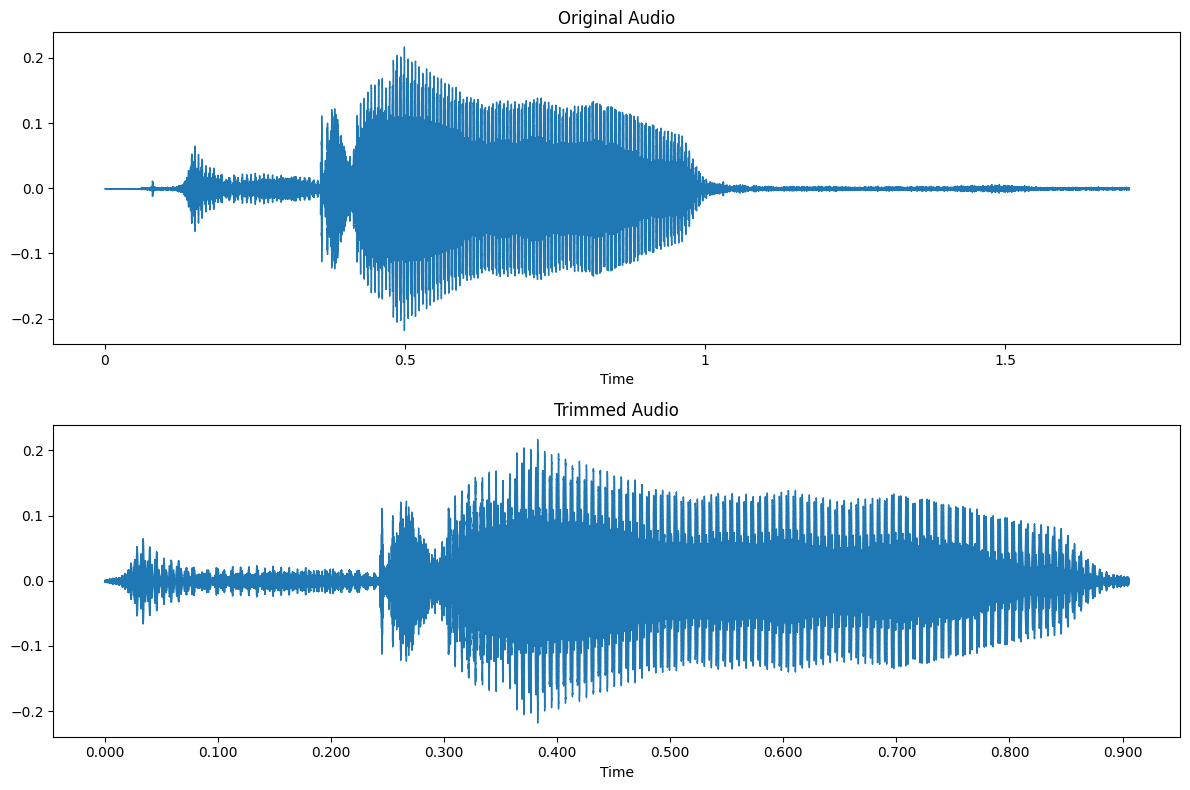

In [102]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Load the audio file using librosa.load
audio_file_path = "/kaggle/input/hijaiyah-all3/Hijaiyah-fix/Hijaiyah dammah/5_Ju/Dhamma_ju_14.wav"
y, sr = librosa.load(audio_file_path)

# Set a custom threshold for trimming (adjust as needed)
custom_top_db = 20

# Trim leading and trailing silence with a custom threshold
y_trimmed, index = librosa.effects.trim(y, top_db=custom_top_db)

# Trim leading and trailing silence with a custom threshold
y_trimmed2, index = librosa.effects.trim(y, top_db=22)

# Plot the original and trimmed audio waveforms
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
librosa.display.waveshow(y, sr=sr)
plt.title('Original Audio')

plt.subplot(2, 1, 2)
librosa.display.waveshow(y_trimmed, sr=sr)
plt.title('Trimmed Audio')

# plt.subplot(2, 1, 1)
# librosa.display.waveshow(y_trimmed2, sr=sr)
# plt.title('Trimmed Audio 2')

plt.tight_layout()
plt.show()
file_name = "trimmed_ghu"
# Save the trimmed audio to a new file
# Save the trimmed audio to a new file
# librosa.output.write_wav("/kaggle/working/trimmed_dza.wav", y_trimmed, sr)

import soundfile as sf

# Specify the file path for saving the trimmed audio
output_file_path = "/kaggle/working/trimmed_zhua.wav"

# Save the trimmed audio to a new file
sf.write(output_file_path, y_trimmed, sr)



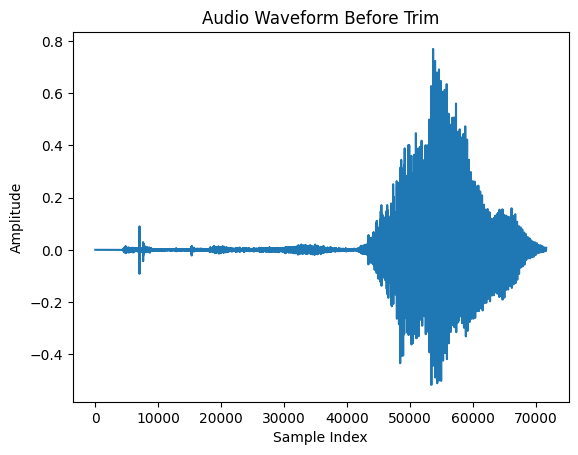

sr :  tf.Tensor(44100, shape=(), dtype=int64)
wav :  (25600,)
tf.Tensor(
[-0.00189209  0.01065063  0.02999878 ...  0.01544189  0.01394653
  0.01278687], shape=(25600,), dtype=float32)


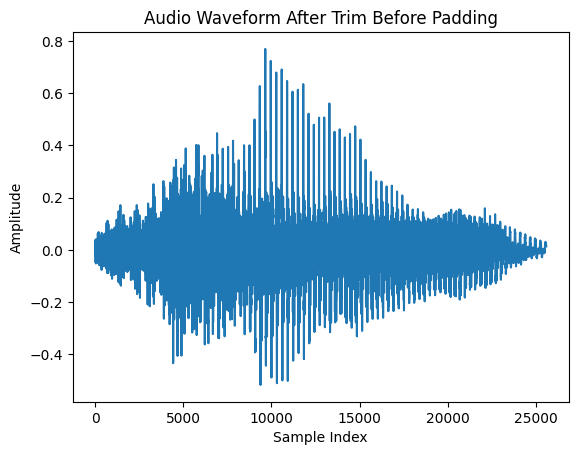

sr :  tf.Tensor(44100, shape=(), dtype=int64)
wav 16k :  (9287,)
tf.Tensor(
[ 1.5301824e-08 -1.0342070e-07  1.0939473e-06 ... -7.9124207e-03
 -8.0152443e-03 -5.9127756e-03], shape=(9287,), dtype=float32)
wav :  (18000,)
sr :  44100.0


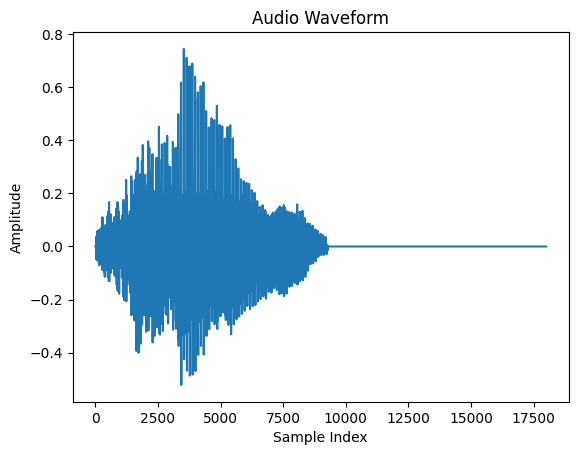

mfcc :  (20, 36)
sr :  44100.0


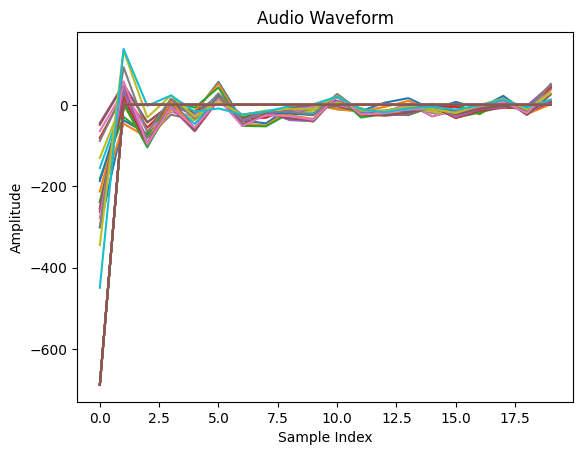

mfcc :  (20,)
sr :  44100.0


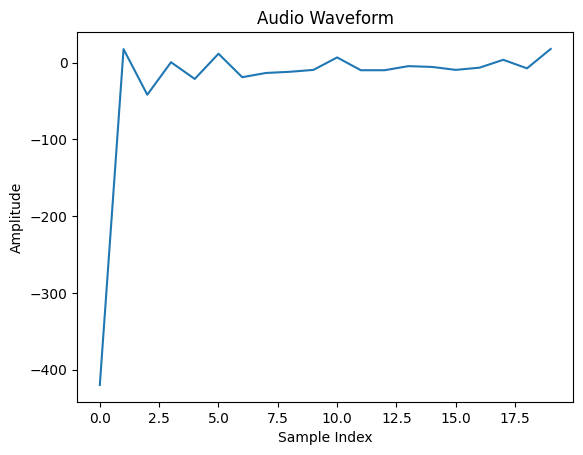

mfcc :  (20, 1)
sr :  44100.0


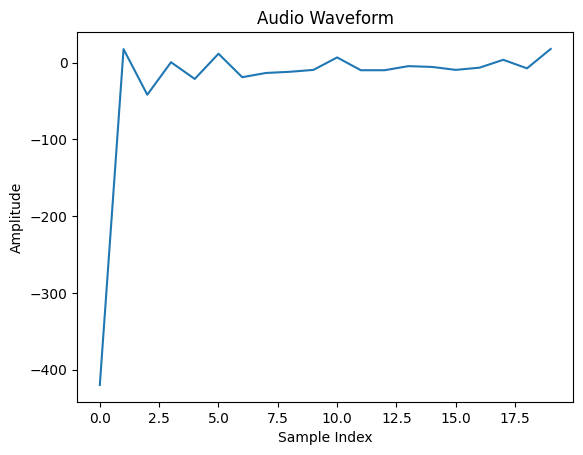

The shape of spectrogram_librosa is:  (513, 57)
The size of the spectrogram is ([(frame_size/2) + 1 x number of frames])
The frame size that we have specified is the number of samples to consider for the STFT. In our case, it is equal to the n_fft 1024  samples
The number of frames depends on the total length of the sampled signal, the number of samples in each frame and the hop length.


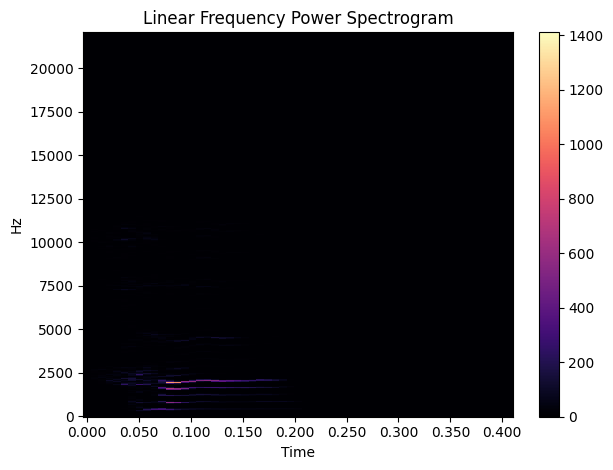

The shape of mel spectrogram is:  (128, 57)


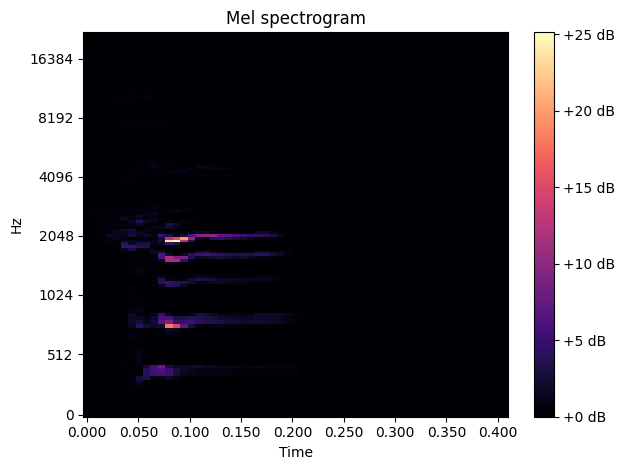

The shape of Log Mel spectrogram is:  (128, 57)
The shape of Log Mel spectrogram is:  [[-68.12198  -75.096466 -80.       ... -80.       -80.       -80.      ]
 [-67.02298  -74.52376  -80.       ... -80.       -80.       -80.      ]
 [-64.53582  -72.621506 -79.53095  ... -80.       -80.       -80.      ]
 ...
 [-65.700424 -58.80998  -54.12533  ... -80.       -80.       -80.      ]
 [-73.83389  -70.68852  -64.201645 ... -80.       -80.       -80.      ]
 [-80.       -80.       -80.       ... -80.       -80.       -80.      ]]


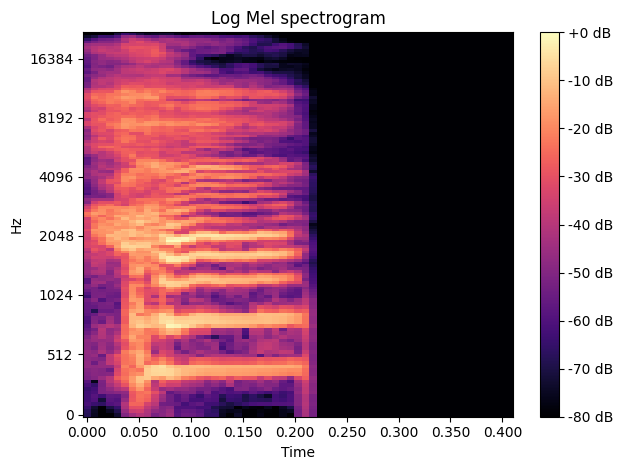

The shape of Log Mel spectrogram is:  (128, 57)
The shape of Log Mel spectrogram is:  [[-80. -80. -80. ... -80. -80. -80.]
 [-80. -80. -80. ... -80. -80. -80.]
 [-80. -80. -80. ... -80. -80. -80.]
 ...
 [-80. -80. -80. ... -80. -80. -80.]
 [-80. -80. -80. ... -80. -80. -80.]
 [-80. -80. -80. ... -80. -80. -80.]]


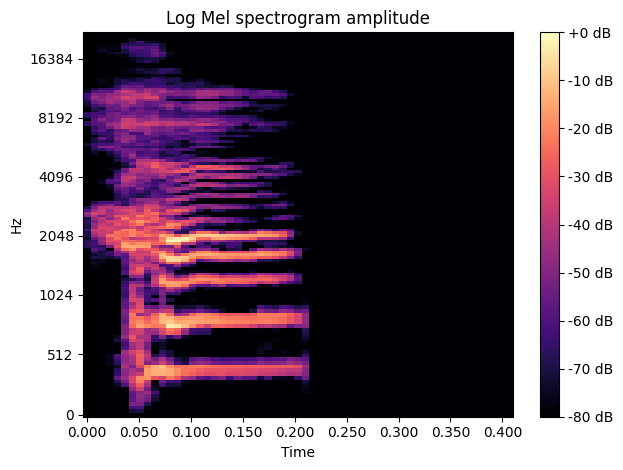

mfcc :  (128, 57)
sr :  44100.0


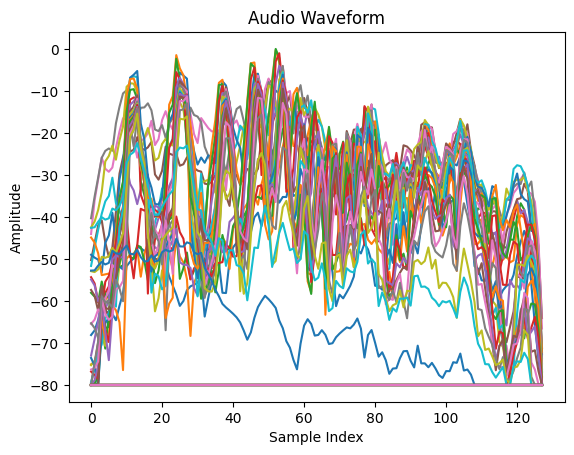

mfcc :  (128,)
sr :  44100.0


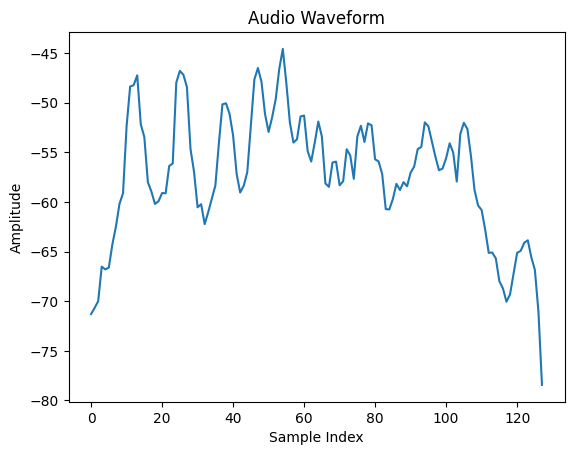

The shape of Log Mel spectrogram is:  (128, 57, 3)
The shape of Log Mel spectrogram is:  [[[1.00000000e+00 2.18591140e-01 0.00000000e+00]
  [7.67379679e-01 0.00000000e+00 0.00000000e+00]
  [5.00000000e-01 0.00000000e+00 0.00000000e+00]
  ...
  [5.00000000e-01 0.00000000e+00 0.00000000e+00]
  [5.00000000e-01 0.00000000e+00 0.00000000e+00]
  [5.00000000e-01 0.00000000e+00 0.00000000e+00]]

 [[1.00000000e+00 2.62164125e-01 0.00000000e+00]
  [8.03030303e-01 0.00000000e+00 0.00000000e+00]
  [5.00000000e-01 0.00000000e+00 0.00000000e+00]
  ...
  [5.00000000e-01 0.00000000e+00 0.00000000e+00]
  [5.00000000e-01 0.00000000e+00 0.00000000e+00]
  [5.00000000e-01 0.00000000e+00 0.00000000e+00]]

 [[1.00000000e+00 3.78358751e-01 0.00000000e+00]
  [9.09982175e-01 7.26216412e-04 0.00000000e+00]
  [5.17825312e-01 0.00000000e+00 0.00000000e+00]
  ...
  [5.00000000e-01 0.00000000e+00 0.00000000e+00]
  [5.00000000e-01 0.00000000e+00 0.00000000e+00]
  [5.00000000e-01 0.00000000e+00 0.00000000e+00]]

 ...


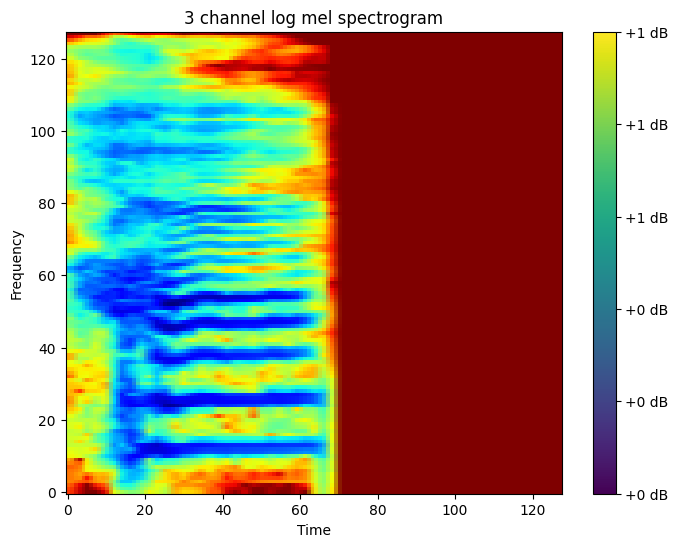

The shape of Log Mel spectrogram is:  (128, 57, 3)
The shape of Log Mel spectrogram is:  [[[0.5 0.  0. ]
  [0.5 0.  0. ]
  [0.5 0.  0. ]
  ...
  [0.5 0.  0. ]
  [0.5 0.  0. ]
  [0.5 0.  0. ]]

 [[0.5 0.  0. ]
  [0.5 0.  0. ]
  [0.5 0.  0. ]
  ...
  [0.5 0.  0. ]
  [0.5 0.  0. ]
  [0.5 0.  0. ]]

 [[0.5 0.  0. ]
  [0.5 0.  0. ]
  [0.5 0.  0. ]
  ...
  [0.5 0.  0. ]
  [0.5 0.  0. ]
  [0.5 0.  0. ]]

 ...

 [[0.5 0.  0. ]
  [0.5 0.  0. ]
  [0.5 0.  0. ]
  ...
  [0.5 0.  0. ]
  [0.5 0.  0. ]
  [0.5 0.  0. ]]

 [[0.5 0.  0. ]
  [0.5 0.  0. ]
  [0.5 0.  0. ]
  ...
  [0.5 0.  0. ]
  [0.5 0.  0. ]
  [0.5 0.  0. ]]

 [[0.5 0.  0. ]
  [0.5 0.  0. ]
  [0.5 0.  0. ]
  ...
  [0.5 0.  0. ]
  [0.5 0.  0. ]
  [0.5 0.  0. ]]]
The shape of Log Mel spectrogram is:  (128, 128, 3)
The shape of Log Mel spectrogram is:  [[[0.5 0.  0. ]
  [0.5 0.  0. ]
  [0.5 0.  0. ]
  ...
  [0.5 0.  0. ]
  [0.5 0.  0. ]
  [0.5 0.  0. ]]

 [[0.5 0.  0. ]
  [0.5 0.  0. ]
  [0.5 0.  0. ]
  ...
  [0.5 0.  0. ]
  [0.5 0.  0. ]
 

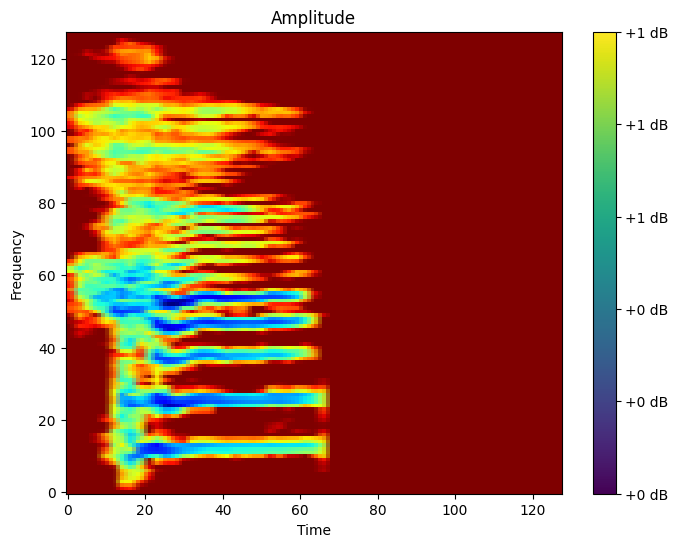

In [134]:
## Testing Audio Processing 

filep = "/kaggle/input/dataset-hijaiyah/Dataset Hijaiyah/Hijaiyah-full/A/1_a_1_1.wav"
filer = "/kaggle/input/dataset-hijaiyah/Dataset Hijaiyah/Hijaiyah-full/Mim/2_3_NT_Meem_T19.wav"
dza_ardan = "/kaggle/input/hijaiyah-fathahh/Hijaiyah fathahh/Hijaiyah fathah/9_Dza/9_dza_6.wav"
har = "/kaggle/input/hijaiyah-fathahh/Hijaiyah fathahh/Hijaiyah fathah/6_HA/6_ha_1.wav"
target_length = 18000
wav, sr = librosa.load(har, sr = None)

plt.plot(wav)
plt.title('Audio Waveform Before Trim')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.show()
# Set a custom threshold for trimming (adjust as needed)
custom_top_db = 20
# Trim leading and trailing silence with a custom threshold
wav, _ = librosa.effects.trim(wav, top_db=custom_top_db)

wav = tf.convert_to_tensor(wav, dtype=tf.float32)
sr = tf.convert_to_tensor(sr, dtype=tf.int64)
print("sr : ", sr)
print("wav : ", wav.shape)
print(wav)
#sr = float(sr)
# Plot the audio waveform
plt.plot(wav)
plt.title('Audio Waveform After Trim Before Padding')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.show()
#file_contents = tf.io.read_file(filer)

# wav, sample_rate = tf.audio.decode_wav(
#           file_contents,
#            desired_channels=1)
#wav, samplerate = soundfile.read(filer)
#wav = tf.squeeze(wav, axis=-1)
#sample_rate = tf.cast(sr, dtype=tf.float64)
wav = tfio.audio.resample(wav, rate_in=sr, rate_out=16000)
print("sr : ", sr)
print("wav 16k : ", wav.shape)
print(wav)
# wav = pad_sequences([wav.numpy()], maxlen=4000, padding='post')[0]
# Adjust the length of the audio sequence
if len(wav) < target_length:
    # Zero-pad if the sequence is shorter than the target length
    pad_size = target_length - len(wav)
    wav = tf.pad(wav, paddings=[[0, pad_size]])
elif len(wav) > target_length:
    # Trim if the sequence is longer than the target length
     wav = wav[:target_length]
wav = np.array(wav)
sr = float(sr)
print("wav : ", wav.shape)
print("sr : ", sr)
 
# Plot the audio waveform
plt.plot(wav)
plt.title('Audio Waveform')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.show()

#MFCC
mfcc = librosa.feature.mfcc(y=wav, sr=sr)

print("mfcc : ", mfcc.shape)
print("sr : ", sr)

plt.plot(mfcc)
plt.title('Audio Waveform')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.show()

#MFCC Scaled
mfccScaled = np.mean(mfcc.T, axis=0)
print("mfcc : ", mfccScaled.shape)
print("sr : ", sr)

plt.plot(mfccScaled)
plt.title('Audio Waveform')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.show()

mffccScaled = mfccScaled.reshape(20, 1)
print("mfcc : ", mffccScaled.shape)
print("sr : ", sr)

plt.plot(mfccScaled)
plt.title('Audio Waveform')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.show()

#TAHAP 2
# Size of the Fast Fourier Transform (FFT), which will also be used as the window length
n_fft=1024

# Step or stride between windows. If the step is smaller than the window length, the windows will overlap
hop_length=320
# Specify the window type for FFT/STFT
window_type ='hann'

#sr = float(sr)
# Calculate the spectrogram as the square of the complex magnitude of the STFT
spectrogram_librosa = np.abs(librosa.stft(wav, n_fft=n_fft, hop_length=hop_length, win_length=n_fft, window=window_type)) ** 2

print("The shape of spectrogram_librosa is: ", spectrogram_librosa.shape)
print("The size of the spectrogram is ([(frame_size/2) + 1 x number of frames])")
print("The frame size that we have specified is the number of samples to consider for the STFT. In our case, it is equal to the n_fft",n_fft, " samples")
print("The number of frames depends on the total length of the sampled signal, the number of samples in each frame and the hop length.")

librosa.display.specshow(spectrogram_librosa, sr=sr, x_axis='time', y_axis='linear',hop_length=hop_length)
plt.title('Linear Frequency Power Spectrogram')
plt.colorbar()
plt.tight_layout()
plt.show()

#TAHAP 3
# sr = float(sr)
mel_bins = 128 # Number of mel bands
fmin = 0
fmax= None
Mel_spectrogram = librosa.feature.melspectrogram(y=wav, sr=sr, n_fft=n_fft, hop_length=hop_length, win_length=n_fft, window=window_type, n_mels = mel_bins, power=2.0)
print("The shape of mel spectrogram is: ", Mel_spectrogram.shape)

librosa.display.specshow(Mel_spectrogram, sr=sr, x_axis='time', y_axis='mel',hop_length=hop_length)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()
plt.show()

#tahap 4
mel_spectrogram_db = librosa.power_to_db(Mel_spectrogram, ref=np.max)
print("The shape of Log Mel spectrogram is: ", mel_spectrogram_db.shape)
print("The shape of Log Mel spectrogram is: ", mel_spectrogram_db)
librosa.display.specshow(mel_spectrogram_db, sr=sr, x_axis='time', y_axis='mel',hop_length=hop_length)
plt.colorbar(format='%+2.0f dB')
plt.title('Log Mel spectrogram')
plt.tight_layout()
plt.show()

spec_amplit = librosa.amplitude_to_db(Mel_spectrogram, ref=np.max)
print("The shape of Log Mel spectrogram is: ", spec_amplit.shape)
print("The shape of Log Mel spectrogram is: ", spec_amplit)
librosa.display.specshow(spec_amplit, sr=sr, x_axis='time', y_axis='mel',hop_length=hop_length)
plt.colorbar(format='%+2.0f dB')
plt.title('Log Mel spectrogram amplitude')
plt.tight_layout()
plt.show()

#MFCC spectro
# mfcc = librosa.feature.mfcc(y=mel_spectrogram_db, sr=sr)
mfcc = mel_spectrogram_db
print("mfcc : ", mfcc.shape)
print("sr : ", sr)

plt.plot(mfcc)
plt.title('Audio Waveform')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.show()

#MFCC Scaled
mfccScaled = np.mean(mfcc.T, axis=0)
print("mfcc : ", mfccScaled.shape)
print("sr : ", sr)

plt.plot(mfccScaled)
plt.title('Audio Waveform')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.show()

# Plot spektrogram dengan label sebagai judul
# plt.figure(figsize=(8, 6))
# plt.imshow(wav)
# plt.title(f"Spectrogram for Sample {sample_index_to_visualize} - Label: {sample_label}")
# plt.xlabel("Time")
# plt.ylabel("Frequency")
# plt.colorbar(format='%+2.0f dB')
# plt.show()

cmap = plt.get_cmap('jet')  # You can choose other colormaps
wav = cmap(mel_spectrogram_db / np.min(mel_spectrogram_db))[:, :, :3]
#wav = mel_spectrogram_db[:, :, np.newaxis]
print("The shape of Log Mel spectrogram is: ", wav.shape) 
print("The shape of Log Mel spectrogram is: ", wav)

# # Compute the spectrogram
# spec = np.abs(librosa.stft(wav))

# # Convert to dB scale
# wav = librosa.amplitude_to_db(spec, ref=np.max)
# print("The shape of Log Mel spectrogram is: ", wav.shape) 
# print("The shape of Log Mel spectrogram is: ", wav)
# Resize the spectrogram
wav = tf.image.resize(wav, size=(128, 128)).numpy()
print("The shape of Log Mel spectrogram is: ", wav.shape) 
print("The shape of Log Mel spectrogram is: ", wav)


# Plot spektrogram dengan label sebagai judul
plt.figure(figsize=(8, 6))
plt.imshow(wav, aspect='auto', cmap='viridis', origin='lower')
plt.title("3 channel log mel spectrogram")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format='%+2.0f dB')
plt.show()


cmap = plt.get_cmap('jet')  # You can choose other colormaps
wav = cmap(spec_amplit / np.min(spec_amplit))[:, :, :3]
#wav = mel_spectrogram_db[:, :, np.newaxis]
print("The shape of Log Mel spectrogram is: ", wav.shape) 
print("The shape of Log Mel spectrogram is: ", wav)

# # Compute the spectrogram
# spec = np.abs(librosa.stft(wav))

# # Convert to dB scale
# wav = librosa.amplitude_to_db(spec, ref=np.max)
# print("The shape of Log Mel spectrogram is: ", wav.shape) 
# print("The shape of Log Mel spectrogram is: ", wav)
# Resize the spectrogram
wav = tf.image.resize(wav, size=(128, 128)).numpy()
print("The shape of Log Mel spectrogram is: ", wav.shape) 
print("The shape of Log Mel spectrogram is: ", wav)

# Plot spektrogram dengan label sebagai judul
plt.figure(figsize=(8, 6))
plt.imshow(wav, aspect='auto', cmap='viridis', origin='lower')
plt.title(f"Amplitude")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format='%+2.0f dB')
plt.show()

# Labeling and Split Data

In [91]:
data_path_fathah = "/kaggle/input/dataset-hijaiyah/Dataset Hijaiyah/Hijaiyah fathah"
data_path_fathahh = "/kaggle/input/hijaiyah-fathahh/Hijaiyah fathahh/Hijaiyah fathah"
data_path_polos = "/kaggle/input/dataset-hijaiyah/Dataset Hijaiyah/Hijaiyah polos"
data_path_full = '/kaggle/input/dataset-hijaiyah/Dataset Hijaiyah/Hijaiyah-full'
data_path_kasrah = '/kaggle/input/dataset-hijaiyah/Dataset Hijaiyah/Hijaiyah kasrah'
data_path_dammah = '/kaggle/input/dataset-hijaiyah/Dataset Hijaiyah/Hijaiyah dammah'

data_path_fathah2 = "/kaggle/input/hijaiyah-all/Dataset Hijaiyah/Hijaiyah fathah"
data_path_polos2 = "/kaggle/input/hijaiyah-all/Dataset Hijaiyah/Hijaiyah polos"
data_path_full2 = '/kaggle/input/hijaiyah-full2/Hijaiyah full'
data_path_kasrah2 = '/kaggle/input/hijaiyah-all/Dataset Hijaiyah/Hijaiyah kasrah'
data_path_dammah2 = '/kaggle/input/hijaiyah-all/Dataset Hijaiyah/Hijaiyah dammah'

data_path_fathah3 = "/kaggle/input/hijaiyah-all3/Hijaiyah-fix/Hijaiyah fathah"
data_path_polos3 = "/kaggle/input/hijaiyah-all3/Hijaiyah-fix/Hijaiyah polos"
data_path_full3 = '/kaggle/input/hijaiyah-all3/Hijaiyah-fix/Hijaiyah full'
data_path_kasrah3 = '/kaggle/input/hijaiyah-all3/Hijaiyah-fix/Hijaiyah kasrah'
data_path_dammah3 = '/kaggle/input/hijaiyah-all3/Hijaiyah-fix/Hijaiyah dammah'

num_classes = len(os.listdir(data_path_fathah3))
print(os.listdir(data_path_fathah3))
print(num_classes)

['3_Ta', '1_A', '17_Zha', '2_Ba', '16_Tha', '11_Za', '15_Dho', '24_Ma', '12_Sa', '18_Ea', '8_Da', '14_Sha', '26_Hha', '13_Sya', '21_Qa', '23_La', '25_Na', '5_ja', '9_Dza', '6_HA', '7_Kho', '10_Ra', '20_Fa', '19_Gh', '4_Tsa', '22_Ka', '27_Wa', '28_Ya']
28


In [124]:
#Load and preprocess data
data_dir = data_path_full3
data, labels = load_and_preprocess_data(data_dir,18000)
#print("Max WAV Length : ", max_wav)
#Labeling
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
one_hot_labels = to_categorical(encoded_labels)

#split data
X_train, X_test, y_train, y_test = train_test_split(data, one_hot_labels, test_size=0.2, random_state=32, stratify=one_hot_labels)


# Check Data

In [125]:
#Check Data Shape
print("Shape of y_train:", y_train.shape)
print("Data in y_train:")
print(y_train)
print("Shape of x_train:", X_train.shape)
print("Data in x_train:")
print(X_train[0])
print("Shape of y_test:", y_test.shape)
print("Data in y_test:")
print(y_test)
print("Shape of x_test:", X_test.shape)
print("Data in x_test:")
print(X_test[0])

print("Class : ", label_encoder.classes_)
print("Encoded Label : ", encoded_labels)
print(len(encoded_labels))
print(X_train[0])

Shape of y_train: (8700, 101)
Data in y_train:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Shape of x_train: (8700, 128, 75, 3)
Data in x_train:
[[[0.5713012  0.         0.        ]
  [0.84566844 0.16778503 0.        ]
  [1.         0.43645605 0.        ]
  ...
  [0.5        0.         0.        ]
  [0.5        0.         0.        ]
  [0.5        0.         0.        ]]

 [[1.         0.3057371  0.        ]
  [1.         0.54742193 0.        ]
  [1.         0.7588961  0.        ]
  ...
  [0.5        0.         0.        ]
  [0.5        0.         0.        ]
  [0.5        0.         0.        ]]

 [[1.         0.5526507  0.        ]
  [1.         0.78503996 0.        ]
  [0.9529412  0.9494553  0.0341556 ]
  ...
  [0.5        0.         0.        ]
  [0.5        0.         0.        ]
  [0.5        0.         0.        ]]

 ...

 [[0.5        0.         0.        ]
  [0.5    

# Export Label to CSV

In [15]:
#Store Label
import csv

# Assuming label_encoder.classes_ contains your labels
labels = label_encoder.classes_

# Specify the file path where you want to save the labels as CSV
csv_file_path = 'dammah_labels.csv'

# Save the labels as CSV
with open(csv_file_path, 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(['Label'])  # Write a header if needed

    for label in labels:
        csv_writer.writerow([label])

print(f"Labels saved to {csv_file_path}")


Labels saved to fathah_labels.csv


In [94]:
#Read Label
import csv

def load_labels_from_csv(csv_file_path):
    labels = []

    with open(csv_file_path, 'r') as csv_file:
        csv_reader = csv.reader(csv_file)
        next(csv_reader)  # Skip the header row if present

        for row in csv_reader:
            labels.append(row[0])

    return labels

# Example usage:
# csv_file_path = 'labels.csv'
# loaded_labels = load_labels_from_csv(csv_file_path)

# print("Loaded labels:", loaded_labels)


In [44]:
#Number classes
num_classes = len(label_encoder.classes_)
print(num_classes)

29


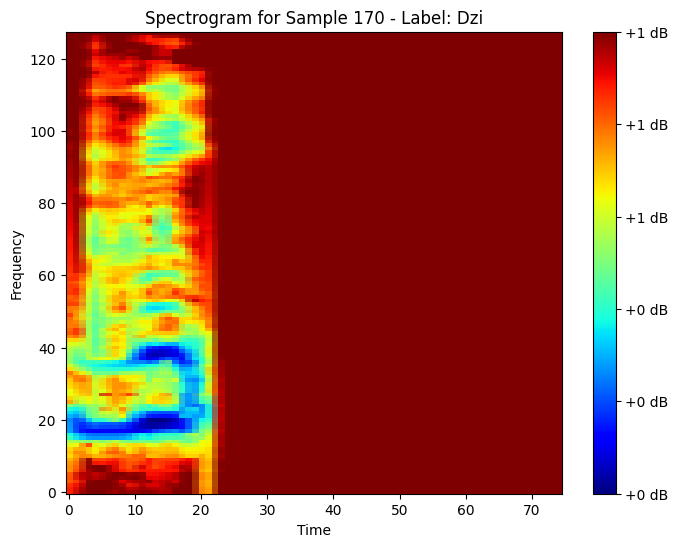

In [126]:
#Check Spectogram

import matplotlib.pyplot as plt

# Pilih salah satu sampel dari X_train
sample_index_to_visualize = 170

# Dapatkan label dari sampel yang dipilih
sample_label = labels[sample_index_to_visualize]

# Plot spektrogram dengan label sebagai judul
plt.figure(figsize=(8, 6))
plt.imshow(data[sample_index_to_visualize], aspect='auto', cmap='jet',origin='lower')
plt.title(f"Spectrogram for Sample {sample_index_to_visualize} - Label: {sample_label}")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format='%+2.0f dB')
plt.show()


(128,)


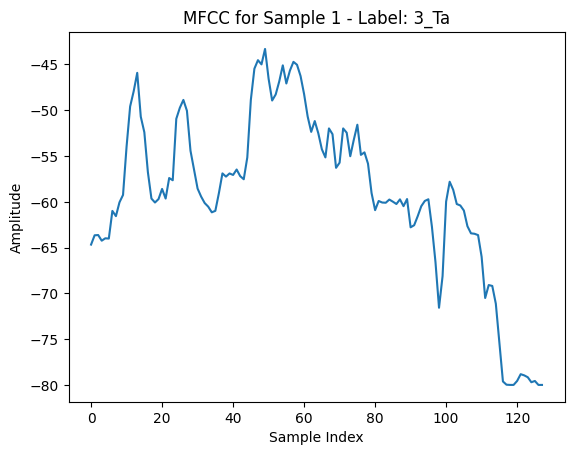

In [136]:
#Check MFCC

import matplotlib.pyplot as plt

# Pilih salah satu sampel dari X_train
sample_index_to_visualize = 1

# Dapatkan label dari sampel yang dipilih
sample_label = labels[sample_index_to_visualize]
#MFCC Scaled
mfccScaled = np.mean(X_train[sample_index_to_visualize].T, axis=0)
print(mfccScaled.shape)

plt.plot(mfccScaled)
plt.title(f"MFCC for Sample {sample_index_to_visualize} - Label: {sample_label}")
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.show()

# Model Manual

In [ ]:
#Model Conv

model = models.Sequential()
model.add(layers.InputLayer(input_shape=(X_train.shape[1], X_train.shape[2],3)))
#model.add(layers.InputLayer(input_shape=(X_train.shape[1])))
#model.add(layers.Reshape((X_train.shape[1], X_train.shape[2], 1)))

model.add(layers.Conv2D(16, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
#model.add(layers.Dropout(0.3))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
#model.add(layers.Dropout(0.3))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
#model.add(layers.Dropout(0.5))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
#model.add(layers.LSTM(32))
#model.add(layers.Dropout(0.3))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(2048, activation='relu'))
model.add(layers.Dense(4096, activation='relu'))
#model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(label_encoder.classes_), activation='softmax'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

In [ ]:
#Model LSTM
# X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
# X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
model = models.Sequential()
#model.add(layers.InputLayer(input_shape=(X_train.shape[1], X_train.shape[2],3)))
# model.add(layers.Conv1D(filters=64, kernel_size=3,
#                                strides=1,
#                                activation="relu",
#                                padding='causal',
#                                input_shape=[20, 1]))
model.add(layers.LSTM(64, input_shape=(None, X_train.shape[1],1), return_sequences=True))
model.add(layers.LSTM(64, return_sequences=True))
layers.LSTM(64),
#model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(2048, activation='relu'))
model.add(layers.Dense(4096, activation='relu'))
#model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(label_encoder.classes_), activation='softmax'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

In [156]:
#Model LSTM
dropout = 0.1

inputs = layers.Input(shape=(128,151), name="input", dtype=tf.float32)

    # expand dims to add channel dimension
input = layers.Lambda(lambda x: tf.expand_dims(x, axis=-1))(inputs)

    # Convolution layer 1
x = layers.Conv2D(filters=32, kernel_size=[11, 41], strides=[2, 2], padding="same", use_bias=False)(input)
x = layers.BatchNormalization()(x)
#x = activation_layer(x, activation="leaky_relu")

    # Convolution layer 2
x = layers.Conv2D(filters=32, kernel_size=[11, 21], strides=[1, 2], padding="same", use_bias=False)(x)
x = layers.BatchNormalization()(x)
#x = activation_layer(x, activation="leaky_relu")
    
    # Reshape the resulted volume to feed the RNNs layers
x = layers.Reshape((-1, x.shape[-2] * x.shape[-1]))(x)

    # RNN layers
x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
#x = layers.Dropout(dropout)(x)

x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
#x = layers.Dropout(dropout)(x)

x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
#x = layers.Dropout(dropout)(x)

x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
#x = layers.Dropout(dropout)(x)

x = layers.Bidirectional(layers.LSTM(128))(x)
x = layers.Flatten()(x)
    # Dense layer
x = layers.Dense(256)(x)
#x = activation_layer(x, activation="leaky_relu")
#x = layers.Dropout(0.1)(x)
 # Classification layer
output = layers.Dense(len(label_encoder.classes_), activation='softmax')(x)
    
model = Model(inputs=inputs, outputs=output)
#model.add(layers.Dense(len(label_encoder.classes_), activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
# Train the model
history = model.fit(X_train, y_train, epochs=200, validation_data=(X_test, y_test))

Model: "model_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 128, 151)]        0         
                                                                 
 lambda_11 (Lambda)          (None, 128, 151, 1)       0         
                                                                 
 conv2d_207 (Conv2D)         (None, 64, 76, 32)        14432     
                                                                 
 batch_normalization_207 (B  (None, 64, 76, 32)        128       
 atchNormalization)                                              
                                                                 
 conv2d_208 (Conv2D)         (None, 64, 38, 32)        236544    
                                                                 
 batch_normalization_208 (B  (None, 64, 38, 32)        128       
 atchNormalization)                                       

# InceptionV3 Model

In [137]:
#Pre-trained Model InceptionV3
from tensorflow.keras import layers
from tensorflow.keras import Model
import urllib.request
from tensorflow.keras.applications.inception_v3 import InceptionV3
inceptionv3 = 'https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
urllib.request.urlretrieve(inceptionv3, 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5')
local_weights_file = 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model =  InceptionV3(input_shape = (128, 75, 3), 
                                include_top = False,
                                weights = "imagenet")

for layer in pre_trained_model.layers:
    layer.trainable = True

last_layer = pre_trained_model.get_layer('mixed8')
last_output = last_layer.output
#pre_trained_model.load_weights(local_weights_file)

In [ ]:
#Pre-trained Model InceptionV3
from tensorflow.keras import layers
from tensorflow.keras import Model
import urllib.request
from tensorflow.keras.applications.inception_v3 import InceptionV3
inceptionv3 = 'https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
urllib.request.urlretrieve(inceptionv3, 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5')

pre_trained_model =  InceptionV3(input_shape = (128, 75, 3), 
                                include_top = False,
                                weights = "imagenet")

for layer in pre_trained_model.layers:
    layer.trainable = True

last_layer = pre_trained_model.get_layer('mixed8')
last_output = last_layer.output

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(len(label_encoder.classes_), activation='softmax')(x)

model = Model(pre_trained_model.input, x)

model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

class myCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs={}):
            if (logs.get('accuracy') > 0.96 and logs.get('val_accuracy') > 0.96 and logs.get('val_loss') < 1 ):
                print("\nstop training!")
                self.model.stop_training = True

callback = myCallback()

history2 = model.fit(X_train, y_train, epochs=200, validation_data=(X_test, y_test), callbacks = [callback])


In [138]:
from tensorflow.keras.regularizers import l2
x = layers.Flatten()(last_output)
#x = layers.Dropout(0.3)(last_output)
#x = layers.Flatten()(x)
#x = layers.Dense(512, activation='relu')(x)
#x = layers.Dense(16, activation='relu')(x)
x = layers.Dense(1024, activation='relu')(x)
#x = layers.Dense(4096, activation='relu')(x)
#x = layers.Dense(1536, activation='relu')(x)
#x = layers.Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(len(label_encoder.classes_), activation='softmax')(x)

model = Model(pre_trained_model.input, x)
#model.summary()
model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

class myCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs={}):
            if (logs.get('accuracy') > 0.96 and logs.get('val_accuracy') > 0.96 and logs.get('val_loss') < 1 ):
                print("\nstop training!")
                self.model.stop_training = True

callback = myCallback()

history2 = model.fit(X_train, y_train, epochs=200, validation_data=(X_test, y_test), callbacks = [callback])

Epoch 1/200
272/272 [==============================] - 42s 54ms/step - loss: 3.0231 - accuracy: 0.1969 - val_loss: 2.8452 - val_accuracy: 0.2915
Epoch 2/200
272/272 [==============================] - 13s 48ms/step - loss: 1.6873 - accuracy: 0.4671 - val_loss: 2.0519 - val_accuracy: 0.4143
Epoch 3/200
272/272 [==============================] - 13s 48ms/step - loss: 1.1774 - accuracy: 0.6175 - val_loss: 1.4444 - val_accuracy: 0.5591
Epoch 4/200
272/272 [==============================] - 13s 48ms/step - loss: 0.8846 - accuracy: 0.6994 - val_loss: 1.1507 - val_accuracy: 0.6418
Epoch 5/200
272/272 [==============================] - 13s 48ms/step - loss: 0.7108 - accuracy: 0.7660 - val_loss: 1.0115 - val_accuracy: 0.6920
Epoch 6/200
272/272 [==============================] - 13s 48ms/step - loss: 0.5494 - accuracy: 0.8153 - val_loss: 0.9921 - val_accuracy: 0.6979
Epoch 7/200
272/272 [==============================] - 13s 48ms/step - loss: 0.4683 - accuracy: 0.8436 - val_loss: 0.9810 - val_ac

In [132]:
model.summary()

Model: "model_25"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_16 (InputLayer)       [(None, 128, 75, 3)]         0         []                            
                                                                                                  
 conv2d_1410 (Conv2D)        (None, 63, 37, 32)           864       ['input_16[0][0]']            
                                                                                                  
 batch_normalization_1410 (  (None, 63, 37, 32)           96        ['conv2d_1410[0][0]']         
 BatchNormalization)                                                                              
                                                                                                  
 activation_1410 (Activatio  (None, 63, 37, 32)           0         ['batch_normalization_1

In [118]:
#Save Model
model.save('model_kasrah_inception_86.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [30]:
#Plot
def plot_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()



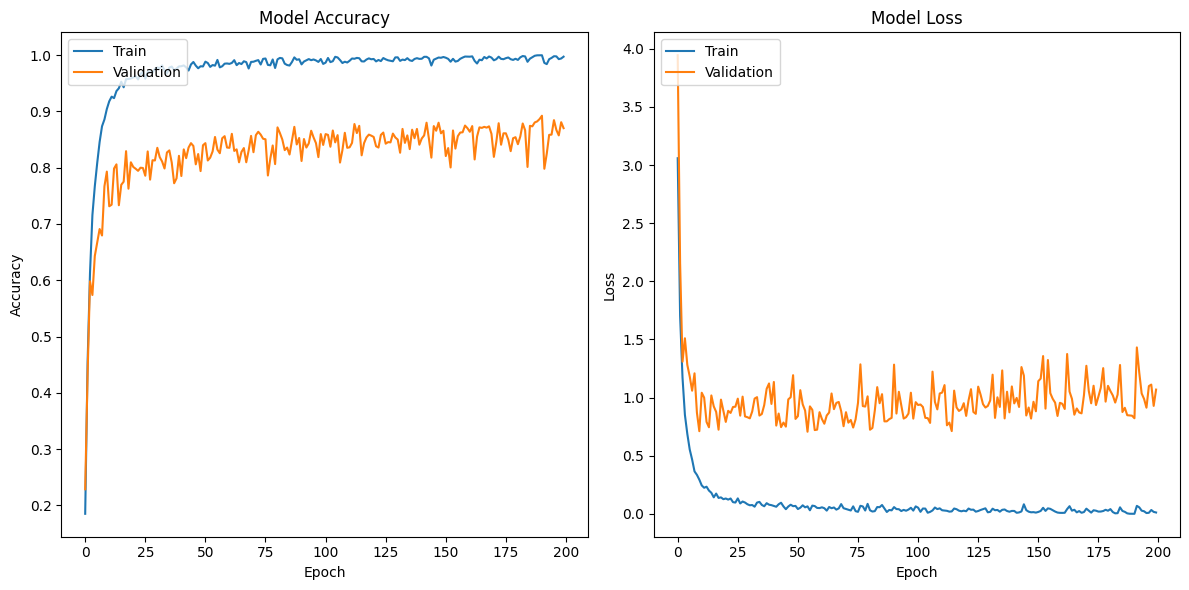

In [129]:
# Call the function to plot the history
plot_history(history2)

# Prediction

In [130]:
y_pred_ = model.predict(X_test, use_multiprocessing=True, workers=6, verbose=1)

68/68 [==============================] - 2s 14ms/step


# Evaluate

In [33]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_true, y_pred, labels, save_path):
    """
    plots the confusion matrix
    """
    matrix = confusion_matrix(y_true, y_pred)    
    fig, ax = plt.subplots(figsize=(20,60))
    #fig, ax = plt.subplots(figsize=(12,10))
    plt.imshow(matrix)
    ax.set_xticks(range(len(labels)));
    ax.set_xticklabels(labels, rotation=0)
    ax.set_yticks(range(len(labels)));
    ax.set_yticklabels(labels)
    max_confusions = 0
    confused_classes = (-1, -1)
    for i, true_label in enumerate(matrix):
        for j, predicted_label in enumerate(true_label):
            text = ax.text(j, i, matrix[i, j],
                        ha="center", va="center", color="w");
    plt.tick_params(axis=u'both', which=u'both',length=0)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix");
    plt.savefig(save_path, format='png', bbox_inches='tight')

prediksi :  [1.17790598e-29 6.90786858e-25 7.47415570e-30 6.37490864e-32
 0.00000000e+00 0.00000000e+00 0.00000000e+00 6.15520703e-30
 2.57041263e-34 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.99490688e-37
 0.00000000e+00 0.00000000e+00 0.00000000e+00 6.31120390e-38
 0.00000000e+00 1.06938505e-17 3.76022061e-30 0.00000000e+00
 4.66834708e-38 1.71238668e-28 9.91342049e-34 1.40193331e-37
 1.90518398e-26 1.54961787e-27 0.00000000e+00 2.95097485e-19
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 6.00311563e-36 0.00000000e+00 0.00000000e+00 9.99999523e-01
 0.00000000e+00 3.31696820e-21 0.00000000e+00 3.74630809e-28
 0.00000000e+00 8.10233301e-36 3.39138280e-28 1.86767303e-32
 9.13320742e-31 0.00000000e+00 0.00000000e+00 2.21905528e-28
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.55296416e-31 1.19384476e-26 4.24548432e-07 7.47186040e-34
 3.78332445e-32 2.62782827e-33 0.00000000e+00 3.13266690e-35
 0.00000000e

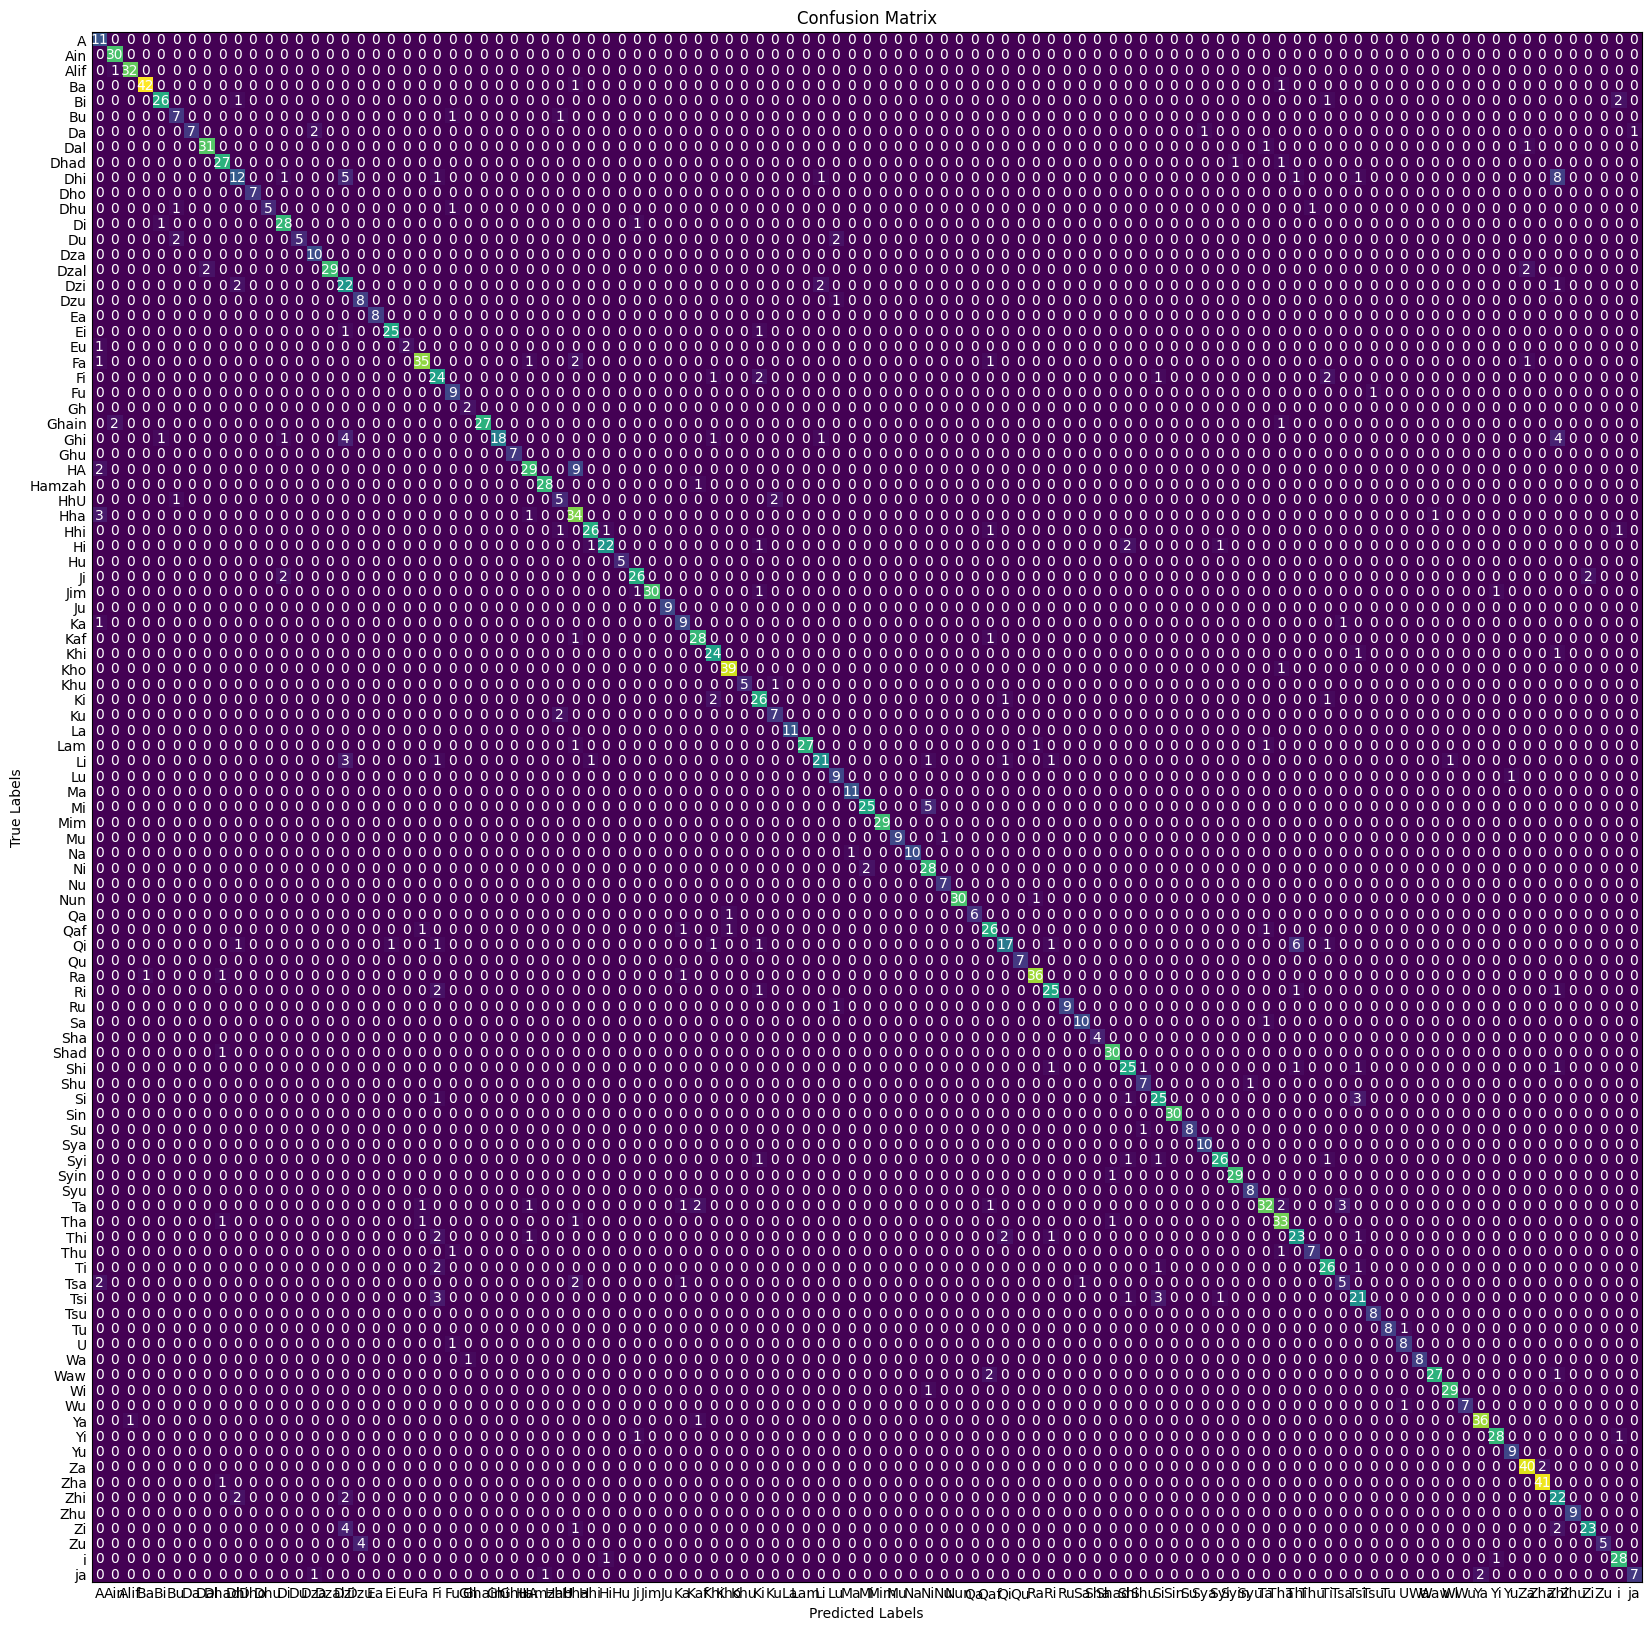

In [131]:
y_pred = np.argmax(y_pred_, axis=1)
y_true = np.argmax(y_test, axis=1)
index = 5
print("prediksi : ", y_pred_[y_pred[index]])
print("yang benar : ", y_test[y_true[index]])

test = np.expand_dims(X_test[index], axis=0)
print("test shape : ", test.shape)
# benar = y_test[index]
prediksi = model.predict(test)
index_prediksi = np.argmax(prediksi, axis=1)
print("prediksi : ", y_pred[index])
print("prediksi shape: ", prediksi.shape)
print("test : ", prediksi)
print("test index : ", index_prediksi)
print("test : ", prediksi[0, index_prediksi])
print("yang benar : ", y_true[index])
print("benar : ", label_encoder.classes_[y_true[index]])
labelss = label_encoder.classes_
save_path = "/kaggle/working/Confusion_matrix_kasrah.png"
plot_confusion_matrix(y_true, y_pred, labelss, save_path)

In [123]:
#Testing Predict
audio_file = "/kaggle/input/hijaiyah-all3/Hijaiyah-fix/Hijaiyah kasrah/15_Dhi/15_dhi_2_2.wav"
true_label = 'ha'
data = process_audio_to_spectrogram4(audio_file, target_length=18000)
data = np.expand_dims(data, axis=0)
predicted = model.predict(data)
top_predict = np.argmax(predicted, axis=1)


print("Predict result : ", predicted)
print("Label index : ", top_predict)
print("Label name : ", label_encoder.classes_[top_predict])
print("Probability : ", predicted[0,top_predict])

1/1 [==============================] - 0s 50ms/step
Predict result :  [[6.4695676e-08 4.2501028e-08 6.8798134e-10 6.3412725e-13 7.5832375e-11
  9.9997151e-01 4.8213260e-09 1.0482484e-05 1.4453551e-11 3.8017173e-08
  3.9915865e-13 1.2289908e-09 3.4974048e-09 2.3943493e-12 1.6309541e-06
  4.5778853e-10 1.7090150e-08 2.3473568e-07 7.5514626e-09 2.6961425e-10
  1.1802424e-08 1.4583251e-12 2.5680477e-11 1.5962224e-08 1.7479353e-08
  2.9874070e-12 1.1581957e-05 4.3157934e-06]]
Label index :  [5]
Label name :  ['15_Dhi']
Probability :  [0.9999715]


# Load Model

In [5]:
from keras.models import load_model

model_path = '/kaggle/input/model-hijaiyah/Model/Fathah/5_fathah_93/model_fathah_inception_93_2.h5'
loaded_model = load_model(model_path)

# Load label from CSV

In [22]:
#Load label from csv
csv_file_path = '/kaggle/input/model-hijaiyah/Model/Fathah/5_fathah_93/fathah_labels.csv'
loaded_labels = load_labels_from_csv(csv_file_path)
print(len(loaded_labels))
print(loaded_labels)


27
['Ra', 'Za', 'Sa', 'Sya', 'Sha', 'Dho', 'Tha', 'Ea', 'Gh', 'A', 'Fa', 'Qa', 'Ka', 'La', 'Ma', 'Na', 'Hha', 'Wa', 'Ya', 'Ba', 'Ta', 'Tsa', 'ja', 'HA', 'Kho', 'Da', 'Dza']


# Predict

In [15]:
def predict_audio(audio_file, true_label, label_list):
    spectrogram = process_audio_to_spectrogram2(audio_file, target_length=18000)
    spectrogram = np.expand_dims(spectrogram, axis=0)
    predicted = loaded_model.predict(spectrogram)
    top_predict_index = np.argmax(predicted, axis=1)
    label_name = label_list[int(top_predict_index)]
    probability = predicted[0,top_predict_index]
    
    return predicted, top_predict_index, label_name, probability

In [23]:
#Testing Predict
audio_file = "/kaggle/input/hijaiyah-all/Dataset Hijaiyah/Hijaiyah fathah/9_Dza/9_dza_14.wav"
true_label = '25_nun'
predicted, top_predict_index, label_name, probability = predict_audio(audio_file, true_label, loaded_labels)

print("Predict result : ", predicted)
print("\nLabel index\t\t: ", top_predict_index)
print("Predicted label name\t: ", label_name)
print("True Label name\t\t: ", true_label)
print("Probability\t\t: ",probability)

1/1 [==============================] - 0s 69ms/step
Predict result :  [[2.3887076e-11 4.7316018e-12 7.8892981e-09 5.2336757e-10 2.6418440e-12
  6.6031165e-13 3.2363071e-11 3.2728492e-12 1.5037580e-10 2.9010118e-15
  9.9999237e-01 6.9413813e-06 2.2368715e-08 5.1318993e-10 7.4409073e-14
  4.3874385e-13 4.6262616e-16 4.1069328e-10 1.7494292e-12 1.6244502e-13
  3.4290915e-07 2.6151529e-08 3.7321783e-07 2.1679023e-11 2.7876809e-10
  1.0682366e-08 3.3926284e-12 4.3184267e-14]]

Label index		:  [10]
Predicted label name	:  Fa
True Label name		:  25_nun
Probability		:  [0.9999924]
